In [1]:
import numpy as np
import matplotlib.pyplot as plt
import time

from helper_functions import grid_from_header, scalar_from_file, random_sampling, grid_sampling

In [2]:
# Setting up RF multifiles configuration
rf_conf = {'rf': {'file': '..\\Ansys\\Outputs_RF\\TrajSimTest.fld'},
        'cy': {'file': '..\\Ansys\\Outputs_RF\\TrajSimTest_Cylinder.fld'},
        'c1': {'file': '..\\Ansys\\Outputs_RF\\TrajSimTest_Cube1.fld'},
        'c2': {'file': '..\\Ansys\\Outputs_RF\\TrajSimTest_Cube2.fld'},
        'c3': {'file': '..\\Ansys\\Outputs_RF\\TrajSimTest_Cube3.fld'}}

In [3]:
# Read data from RF files
rf_grid = {}
rf_magE = {}

for zone in rf_conf:
    
    print(f'Reading zone {zone} ...')
    start_time = time.time()
    rf_grid[zone] = {}
    rf_conf[zone]['min'], rf_conf[zone]['max'], rf_conf[zone]['step'] = grid_from_header(filename=rf_conf[zone]['file'], mode='conf')
    
    xs, ys, zs, magE = scalar_from_file(rf_conf[zone]['file'])
    
    rf_grid[zone]['x'] = xs
    rf_grid[zone]['y'] = ys
    rf_grid[zone]['z'] = zs
    
    rf_grid[zone]['unique_x'] = np.unique(xs)
    rf_grid[zone]['unique_y'] = np.unique(ys)
    rf_grid[zone]['unique_z'] = np.unique(zs)
    
    rf_magE[zone] = magE
    
    end_time = time.time()
    print(f'File Readout Time: {end_time - start_time:.4f} seconds.')

import gc
del xs, ys, zs, magE
gc.collect()

Reading zone rf ...
File Readout Time: 1.5617 seconds.
Reading zone cy ...
File Readout Time: 8.2934 seconds.
Reading zone c1 ...
File Readout Time: 10.1019 seconds.
Reading zone c2 ...
File Readout Time: 13.7251 seconds.
Reading zone c3 ...
File Readout Time: 13.8080 seconds.


0

In [4]:
# Basic Trapping Paramenters
m = 9.1093837e-31
q = -1.60217663e-19
freq = 1.36e+09

# Calculate field from basic data
Ups = {}
rf_force = {}
for zone in rf_conf:
    
    Ups[zone] = (q*rf_magE[zone]) ** 2 / (4 * m * (2*np.pi*freq) ** 2)
    F = np.gradient(Ups[zone], rf_conf[zone]['step'][0])

    rf_force[zone] = {}
    rf_force[zone]['x'] = -F[0] / q
    rf_force[zone]['y'] = -F[1] / q
    rf_force[zone]['z'] = -F[2] / q

# Release RAM if needed
save_Ups = True
if not save_Ups:
    del Ups
del F
gc.collect()

0

In [5]:
from scipy.interpolate import griddata

def fill_NaN_nearest(data, X, Y, Z):
    '''Fill NaN in a data set by its nearest value.'''

    # Get all valid points and values
    valid_mask = ~np.isnan(data)
    valid_points = np.column_stack((X[valid_mask], Y[valid_mask], Z[valid_mask]))
    valid_values = data[valid_mask]

    # Get all points
    all_points = np.column_stack((X.ravel(), Y.ravel(), Z.ravel()))

    # Fill data with nearest method and reshape back to the same shape as data
    filled_data = griddata(valid_points, valid_values, all_points, method='nearest').reshape(data.shape)

    return filled_data

In [6]:
from scipy.interpolate import RegularGridInterpolator

# If we fill NaNs in data with nearest value
fill_NaNs = True
delete_original = False

# Generate interpolation functions
rf_force_filled = {}
rf_interps = {}

for zone in rf_conf:

    print(f'Creating Interpolation Function for zone {zone} ...')
    rf_interps[zone] = {}
    
    if fill_NaNs:
        
        rf_force_filled[zone] = {}
        
        for coord in ('x', 'y', 'z'):
            
            # Fill the force field to eliminate NaNs
            start_time = time.time()
            rf_force_filled[zone][coord] = fill_NaN_nearest(rf_force[zone][coord],
                rf_grid[zone]['x'], rf_grid[zone]['y'], rf_grid[zone]['z'])
            end_time = time.time()
            print(f'Time consumed for filling NaN in {coord} direction: {end_time - start_time:.4f} seconds.')
            
            # Create interpolation with filled data
            start_time = time.time()
            rf_interps[zone][coord] = RegularGridInterpolator(
                (rf_grid[zone]['unique_x'],
                 rf_grid[zone]['unique_y'],
                 rf_grid[zone]['unique_z']),
                rf_force_filled[zone][coord],
                method = 'cubic'
            )
            end_time = time.time()
            print(f'Time consumed for constructing interpolation function in {coord} direction: {end_time - start_time:.4f} seconds.')
    
    else:
        for coord in ('x', 'y', 'z'):
            start_time = time.time()
            rf_interps[zone][coord] = RegularGridInterpolator(
                (rf_grid[zone]['unique_x'],
                 rf_grid[zone]['unique_y'],
                 rf_grid[zone]['unique_z']),
                rf_force[zone][coord],
                method = 'cubic'
            )
            end_time = time.time()
            print(f'Time consumed for constructing interpolation function in {coord} direction: {end_time - start_time:.4f} seconds.')

if delete_original:
    del rf_force
    gc.collect()

Creating Interpolation Function for zone rf ...
Time consumed for filling NaN in x direction: 5.3744 seconds.
Time consumed for constructing interpolation function in x direction: 44.0310 seconds.
Time consumed for filling NaN in y direction: 5.5427 seconds.
Time consumed for constructing interpolation function in y direction: 46.6608 seconds.
Time consumed for filling NaN in z direction: 5.4707 seconds.
Time consumed for constructing interpolation function in z direction: 42.4022 seconds.
Creating Interpolation Function for zone cy ...
Time consumed for filling NaN in x direction: 22.8670 seconds.
Time consumed for constructing interpolation function in x direction: 138.9493 seconds.
Time consumed for filling NaN in y direction: 22.9943 seconds.
Time consumed for constructing interpolation function in y direction: 132.7502 seconds.
Time consumed for filling NaN in z direction: 22.4924 seconds.
Time consumed for constructing interpolation function in z direction: 129.9749 seconds.
Crea

In [7]:
# Interpolators for error testing
test = {}
ref = {}
for zone in rf_conf:
    test[zone] = rf_interps[zone]['x']
    ref[zone] = RegularGridInterpolator(
        (rf_grid[zone]['unique_x'],
         rf_grid[zone]['unique_y'],
         rf_grid[zone]['unique_z']),
        rf_force_filled[zone]['x'],
        method = 'nearest'
    )

In [8]:
def zone_identifier(point, zones=rf_conf):
    """
    Determines which zone a given point belongs to, with zones of smaller stepsize taking priority.
    
    Parameters:
        point (array-like): The (x, y, z) coordinates of the point as a list, tuple, or NumPy array.
        zones (dict, optional): A dictionary of zones with their configurations. Each key is the zone name,
            and each value is a dictionary containing:
                - 'file' (optional for this function): The file path associated with the zone.
                - 'min': A tuple of minimum (x, y, z) coordinates defining the zone boundary.
                - 'max': A tuple of maximum (x, y, z) coordinates defining the zone boundary.
                - 'step': A tuple of stepsizes (dx, dy, dz) for the zone grid.
            Defaults to `rf_conf`, which should be defined elsewhere in your code.
    
    Returns:
        str: The name of the zone to which the point belongs.
    
    Raises:
        ValueError: If the point does not belong to any of the defined zones.
    
    Example:
        >>> rf_conf = {
        ...     'rf': {'file': '...', 'min': (...), 'max': (...), 'step': (...)},
        ...     'c1': {'file': '...', 'min': (...), 'max': (...), 'step': (...)},
        ...     # Add other zones as needed
        ... }
        >>> point = [0.0003, 0.0003, 0.0003]
        >>> zone = zone_identifier(point, zones=rf_conf)
        >>> print(f'Point {point} belongs to zone: {zone}')
        Point [0.0003, 0.0003, 0.0003] belongs to zone: c3
    """
    import numpy as np

    # Convert the input point to a NumPy array for easy manipulation
    point = np.array(point)

    # Function to calculate the maximum stepsize of a zone
    def max_stepsize(zone):
        return max(zone['step'])

    # Sort zones by ascending maximum stepsize (smaller stepsize has higher priority)
    sorted_zones = sorted(zones.items(), key=lambda item: max_stepsize(item[1]))

    # Iterate over the zones in order of priority
    for zone_name, zone_data in sorted_zones:
        min_bounds = np.array(zone_data['min'])
        max_bounds = np.array(zone_data['max'])
        # Check if the point lies within the bounds of the zone
        if np.all(point >= min_bounds) and np.all(point <= max_bounds):
            return zone_name  # Return the name of the zone

    # If the point does not belong to any zone, raise an error
    raise ValueError(f"Point {point} does not belong to any zone.")

In [9]:
def test_interpolation(point, interp_set=test, ref_set=ref):
    '''This function is only for testing
    Compatible with the interp_func_set test or ref above
    Not compatible with rf_interps'''

    zone = zone_identifier(point)
    interp_value = interp_set[zone](point)[0]
    nearest_value = ref_set[zone](point)[0]
    err = interp_value - nearest_value
    relative_err = np.abs(err) / np.abs(nearest_value)
    
    return interp_value, nearest_value, err, relative_err

In [10]:
xrange = (-0.00795, 0.00795)
yrange = (-0.00645, 0.00645)
zrange = (-0.00095, 0.00995)
xsteps = 500
ysteps = 300
zsteps = 300
num_points = 10000

#test_points = grid_sampling(xrange, yrange, zrange, xsteps, ysteps, zsteps)
test_points = random_sampling(xrange, yrange, zrange, num_points)

In [11]:
interp_values = np.zeros(len(test_points))
nearest_values = np.zeros(len(test_points))
errs = np.zeros(len(test_points))
relative_errs = np.zeros(len(test_points))

for i in range(len(test_points[:5])):
    print(i, test_interpolation(test_points[i]))
    interp_values[i], nearest_values[i], errs[i], relative_errs[i] = test_interpolation(test_points[i])

0 (np.float64(0.003890529042087889), np.float64(0.0038600810282743993), np.float64(3.044801381348961e-05), np.float64(0.007887920898671137))
1 (np.float64(0.00290113009342873), np.float64(0.002972539062750103), np.float64(-7.140896932137297e-05), np.float64(0.024022886769167487))
2 (np.float64(-0.10965995958426432), np.float64(-0.11014369247469998), np.float64(0.00048373289043565637), np.float64(0.0043918346985395455))
3 (np.float64(-0.06661761306795493), np.float64(-0.06097540996173748), np.float64(-0.005642203106217443), np.float64(0.09253243413628488))
4 (np.float64(-1.6286220773304383), np.float64(-1.627313742373013), np.float64(-0.0013083349574252168), np.float64(0.0008039844581643802))


In [14]:
# Zone c3 testing
xrange = (-0.00049, 0.00049)
yrange = (-0.00049, 0.00049)
zrange = (-0.00049, 0.00049)
num_points = 10000

#test_points = grid_sampling(xrange, yrange, zrange, xsteps, ysteps, zsteps)
test_points = random_sampling(xrange, yrange, zrange, num_points)

In [18]:
# Baisic Error Analysis
start_time = time.time()

for i in range(len(test_points)):
    interp_values[i], nearest_values[i], errs[i], relative_errs[i] = test_interpolation(test_points[i])

end_time = time.time()
print(f'Computation time: {end_time - start_time:.4f} seconds')

print(f'Maximum Error: \t{np.max(errs):.4f},\tMaximum Relative Error: \t{np.max(relative_errs):.4f}')
print(f'Average Error: \t{np.mean(errs):.4f},\tAverage Relative Error: \t{np.mean(relative_errs):.4f}')
print(f'SD of Error: \t{np.std(errs):.4f},\tSD of Relative Error: \t{np.std(relative_errs):.4f}')

Computation time: 4.0708 seconds
Maximum Error: 	32352.6013,	Maximum Relative Error: 	7.5082
Average Error: 	-19.8037,	Average Relative Error: 	0.0293
SD of Error: 	1525.3994,	SD of Relative Error: 	0.1710


In [ ]:
# Cross Validation
for zone in rf_conf:

Computation time: 2.2400 seconds


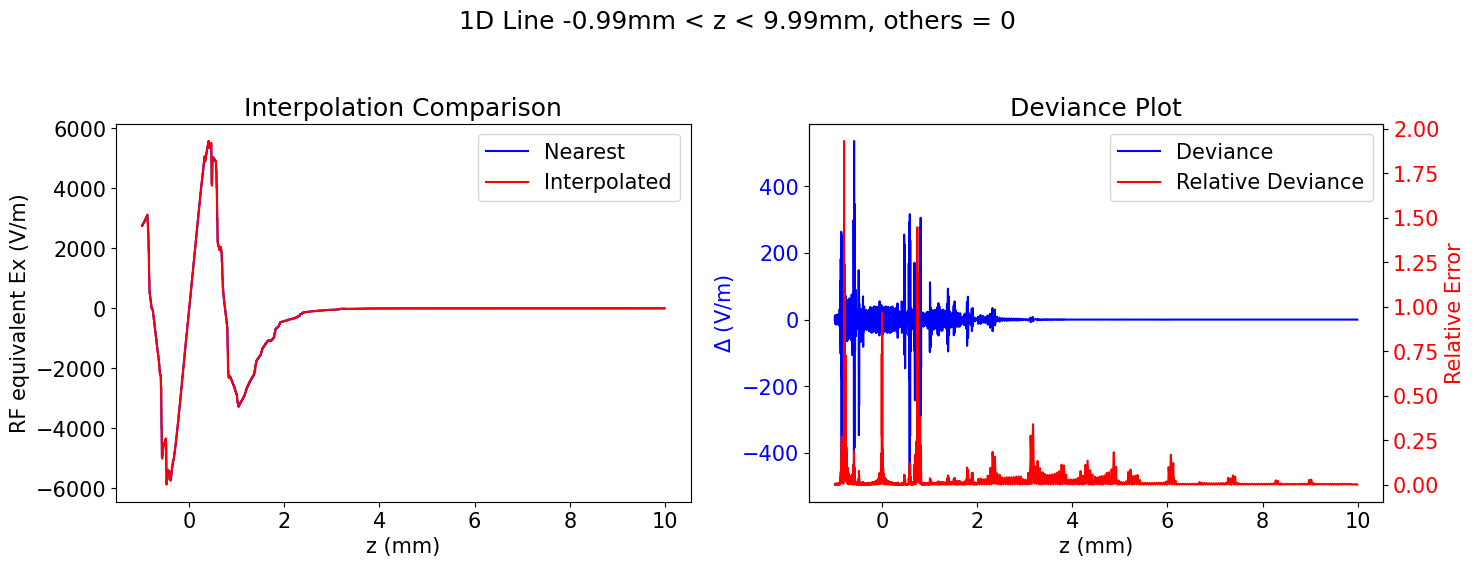

In [83]:
import numpy as np
import time
import matplotlib.pyplot as plt

def sample_and_plot_1D(axis, axis_range, field='x', step=5000, interp_funcs=test, ref_funcs=ref):
    """
    Samples points along a specified axis, performs interpolation, and plots the results.

    Parameters:
    - axis (str): The axis to sample ('x', 'y', or 'z').
    - axis_range (tuple): The range of values for the specified axis.
    - step (int): Number of sampling points.
    - interp_funcs: Set of interpolation functions.
    - ref_funcs: Set of reference functions.
    """
    
    # Generate test points based on the specified axis
    if axis == 'x':
        test_points = grid_sampling(axis_range, (0, 0), (0, 0), step, 1, 1)
    elif axis == 'y':
        test_points = grid_sampling((0, 0), axis_range, (0, 0), 1, step, 1)
    elif axis == 'z':
        test_points = grid_sampling((0, 0), (0, 0), axis_range, 1, 1, step)
    else:
        raise ValueError("Axis must be 'x', 'y', or 'z'.")

    # Initialize arrays to store interpolation results and errors
    interp_values = np.zeros(len(test_points))
    nearest_values = np.zeros(len(test_points))
    errs = np.zeros(len(test_points))
    relative_errs = np.zeros(len(test_points))

    start_time = time.time()
    
    # Perform interpolation for each test point
    for i, point in enumerate(test_points):
        try:
            interp_values[i], nearest_values[i], errs[i], relative_errs[i] = test_interpolation(
                point, interp_set=interp_funcs, ref_set=ref_funcs
            )
        except Exception as e:
            print(f"Error interpolating point {point}: {e}")
            interp_values[i] = np.nan
            nearest_values[i] = np.nan
            errs[i] = np.nan
            relative_errs[i] = np.nan

    end_time = time.time()
    print(f'Computation time: {end_time - start_time:.4f} seconds')

    # Define the plotting axis (assuming plotting along 'z')
    z = np.linspace(axis_range[0], axis_range[1], step) * 1000  # Convert to mm

    # Configure plot aesthetics
    plt.rcParams['font.size'] = 15
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
    fig.suptitle(f'1D Line {axis_range[0]*1000}mm < {axis} < {axis_range[1]*1000}mm, others = 0')

    # === Subplot 1: Interpolation Comparison ===
    ax1.plot(z, nearest_values, 'b-', label='Nearest')
    ax1.plot(z, interp_values, 'r-', label='Interpolated')
    ax1.legend()
    ax1.set_title('Interpolation Comparison')
    ax1.set_xlabel(f'{axis} (mm)')
    ax1.set_ylabel(f'RF equivalent E{field} (V/m)')

    # === Subplot 2: Error Plot ===
    # Plot 'errs' on ax2 in blue
    line1, = ax2.plot(z, errs, 'b-', label='Deviance')
    ax2.set_title('Deviance Plot')
    ax2.set_xlabel(f'{axis} (mm)')
    ax2.set_ylabel(r'$\Delta$ (V/m)', color='b')
    ax2.tick_params(axis='y', labelcolor='b')  # Set y-axis ticks to blue

    # Plot 'relative_errs' on ax3 in red
    ax3 = ax2.twinx()
    line2, = ax3.plot(z, relative_errs, 'r-', label='Relative Deviance')
    ax3.set_ylabel('Relative Error', color='r')
    ax3.tick_params(axis='y', labelcolor='r')  # Set y-axis ticks to red

    # === Combined Legend ===
    # Collect handles and labels from both axes
    lines = [line1, line2]
    labels = [line.get_label() for line in lines]
    # Create a unified legend on ax2
    ax2.legend(lines, labels, loc='upper right')

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # Adjust layout to accommodate suptitle
    plt.show()

# Example function call
sample_and_plot_1D('z', (-0.00099, 0.00999))

Computation time: 2.1712 seconds


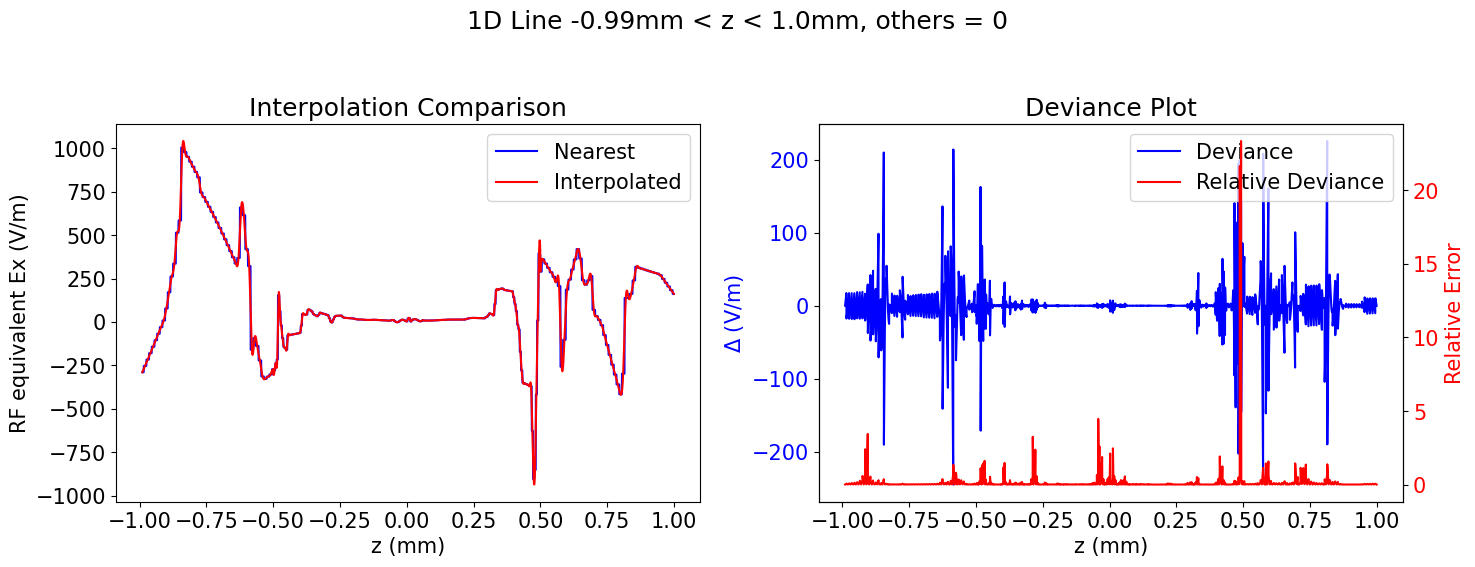

Computation time: 1.8828 seconds


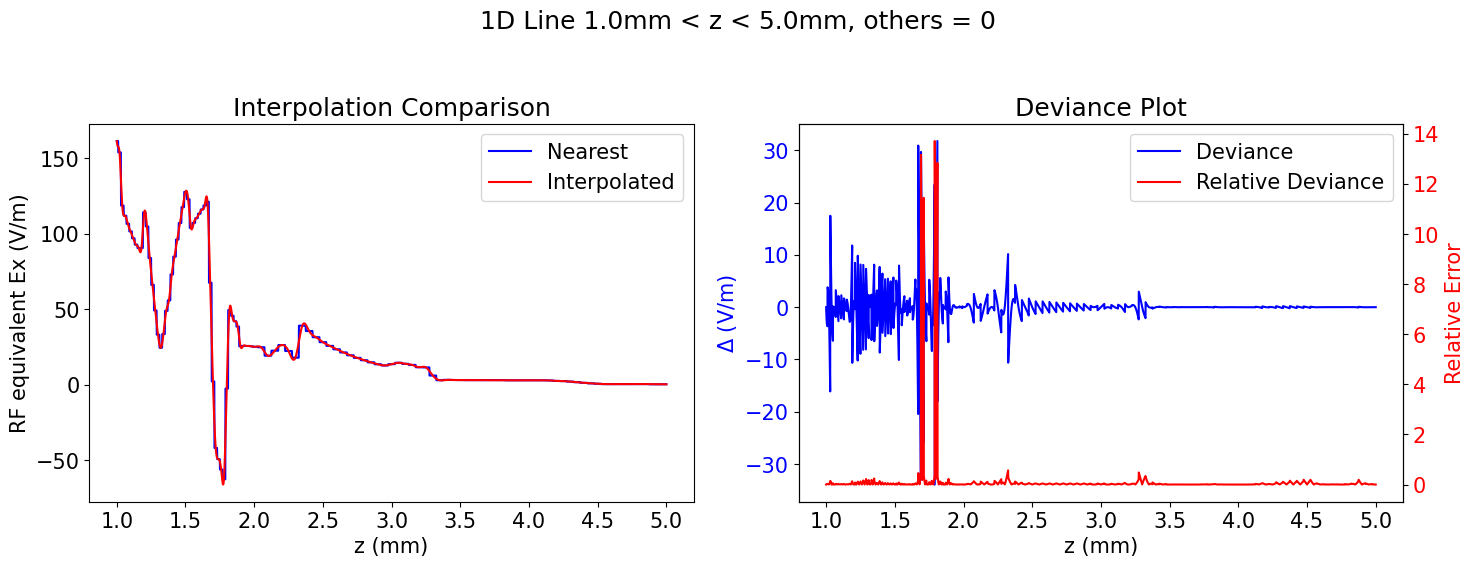

Computation time: 2.1193 seconds


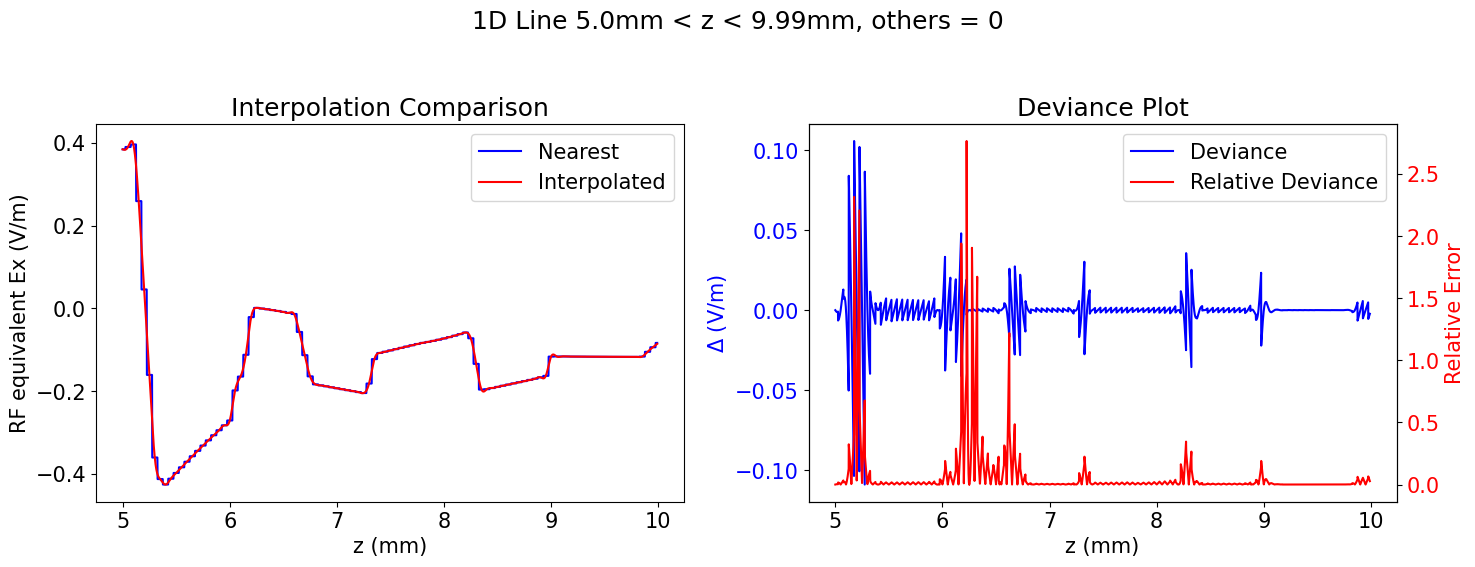

In [62]:
sample_and_plot_1D('z', (-0.00099, 0.001))
sample_and_plot_1D('z', (0.001, 0.005))
sample_and_plot_1D('z', (0.005, 0.00999))

Computation time: 2.2292 seconds


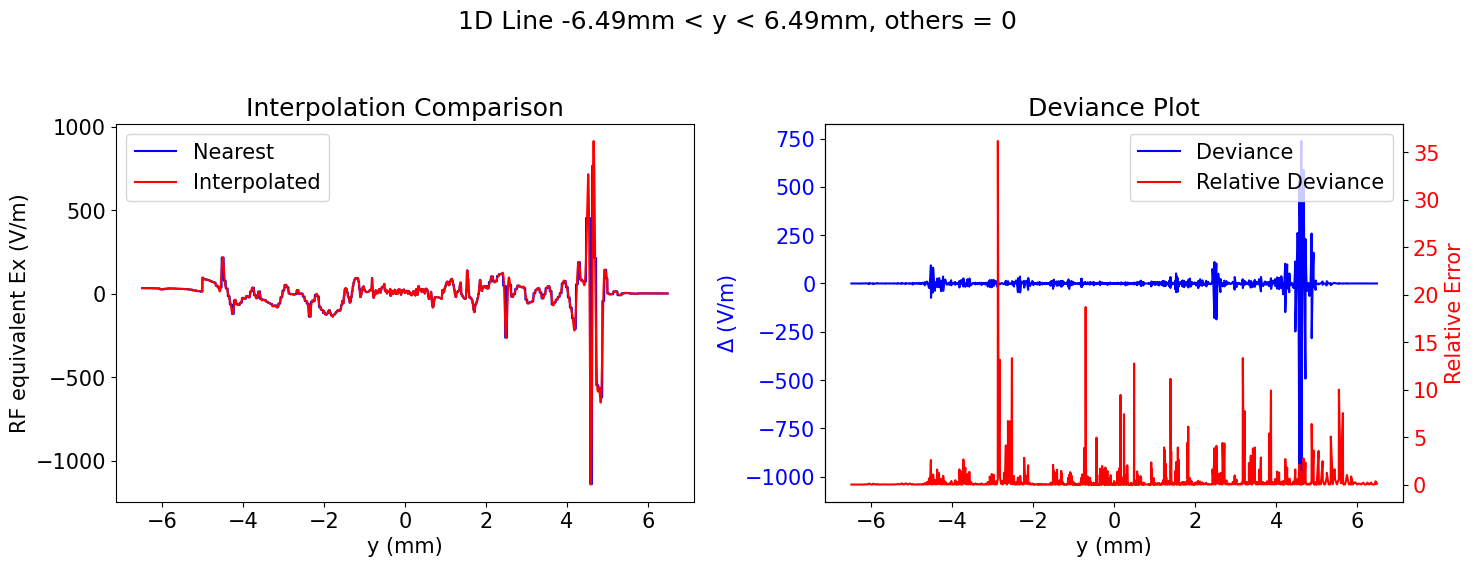

Computation time: 2.4511 seconds


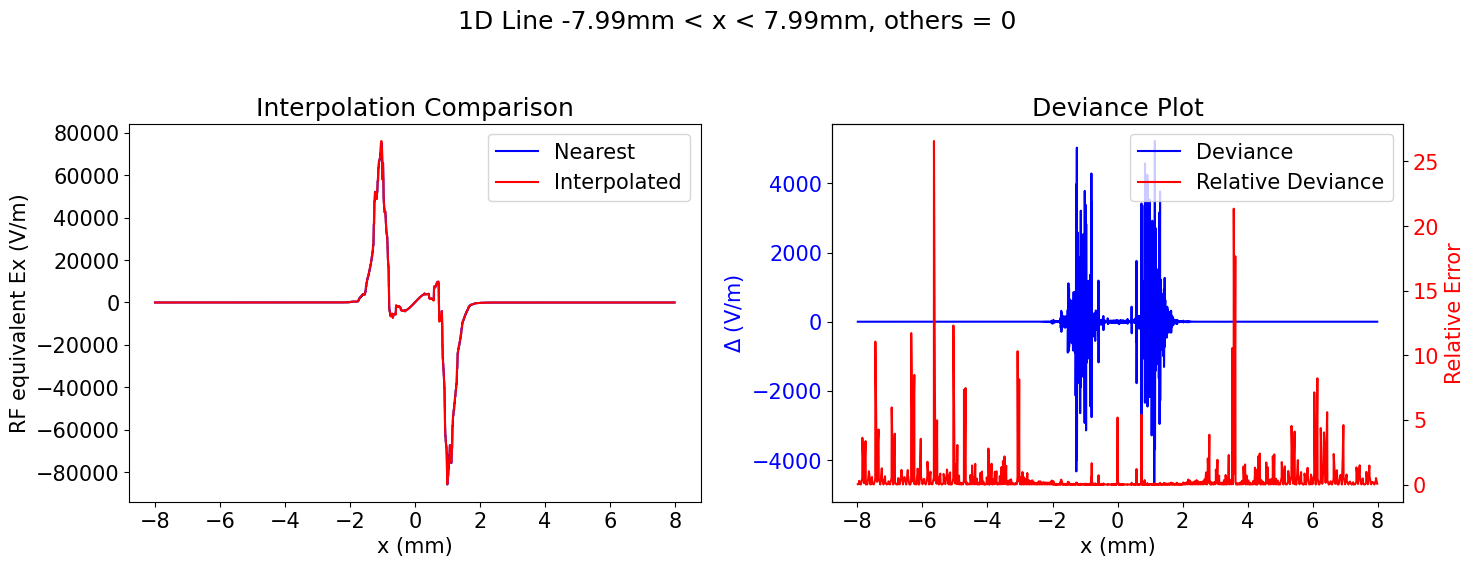

In [63]:
sample_and_plot_1D('y', (-0.00649, 0.00649))
sample_and_plot_1D('x', (-0.00799, 0.00799))

Computation time: 2.2690 seconds


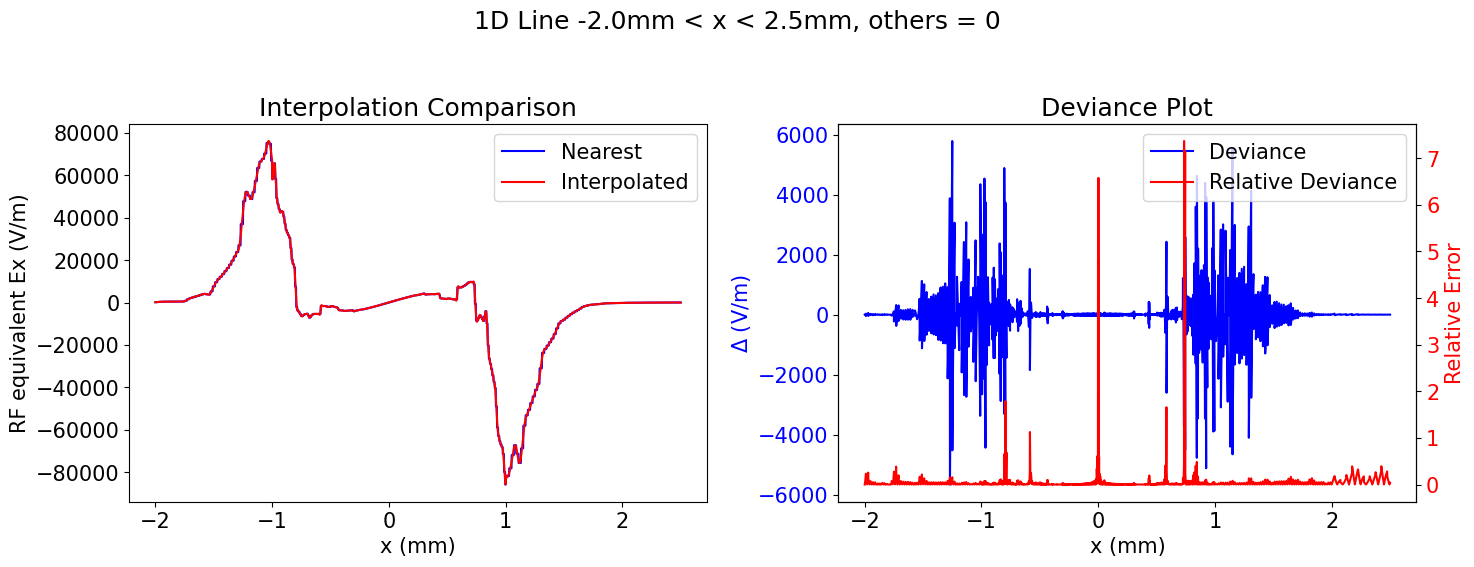

Computation time: 2.4872 seconds


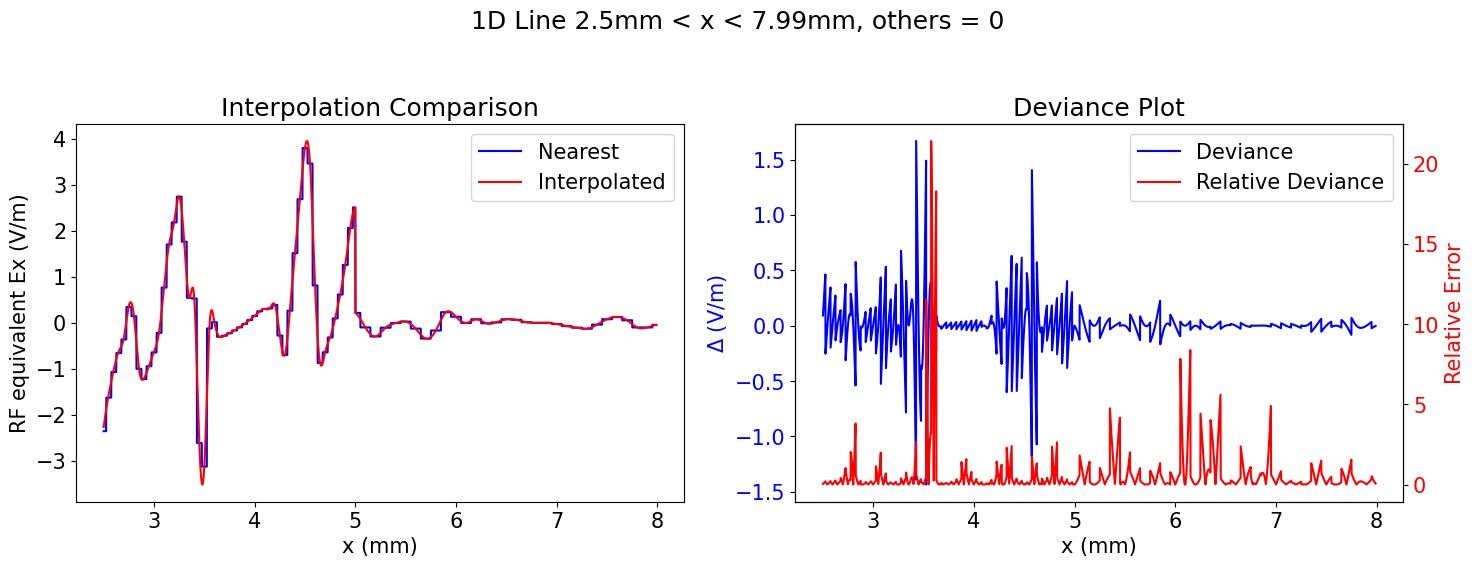

In [65]:
sample_and_plot_1D('x', (-0.002, 0.0025))
sample_and_plot_1D('x', (0.0025, 0.00799))

In [78]:
# Interpolators for error testing
test_z = {}
ref_z = {}
for zone in rf_conf:
    test_z[zone] = rf_interps[zone]['z']
    ref_z[zone] = RegularGridInterpolator(
        (rf_grid[zone]['unique_x'],
         rf_grid[zone]['unique_y'],
         rf_grid[zone]['unique_z']),
        rf_force_filled[zone]['z'],
        method = 'nearest'
    )

test_y = {}
ref_y = {}
for zone in rf_conf:
    test_y[zone] = rf_interps[zone]['y']
    ref_y[zone] = RegularGridInterpolator(
        (rf_grid[zone]['unique_x'],
         rf_grid[zone]['unique_y'],
         rf_grid[zone]['unique_z']),
        rf_force_filled[zone]['y'],
        method = 'nearest'
    )

test_x = {}
ref_x = {}
for zone in rf_conf:
    test_x[zone] = rf_interps[zone]['x']
    ref_x[zone] = RegularGridInterpolator(
        (rf_grid[zone]['unique_x'],
         rf_grid[zone]['unique_y'],
         rf_grid[zone]['unique_z']),
        rf_force_filled[zone]['x'],
        method = 'nearest'
    )

Computation time: 2.0651 seconds


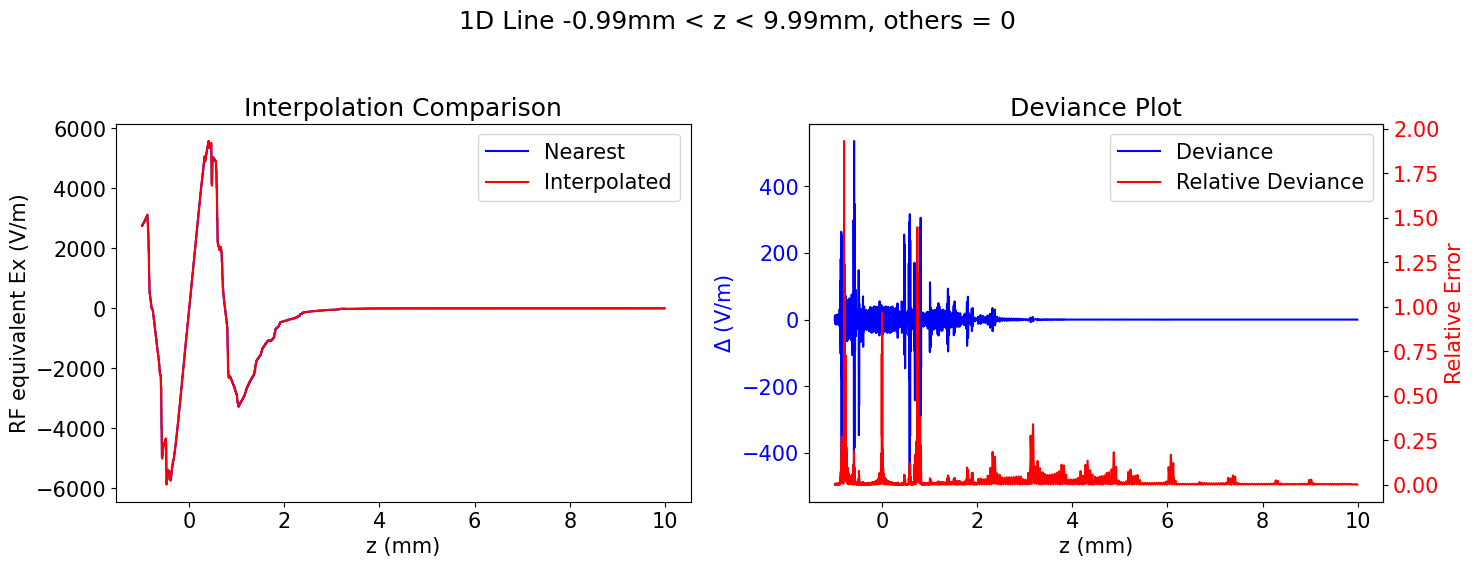

In [73]:
sample_and_plot_1D('z', (-0.00099, 0.00999), interp_funcs=test_z, ref_funcs=ref_z)

Computation time: 2.2648 seconds


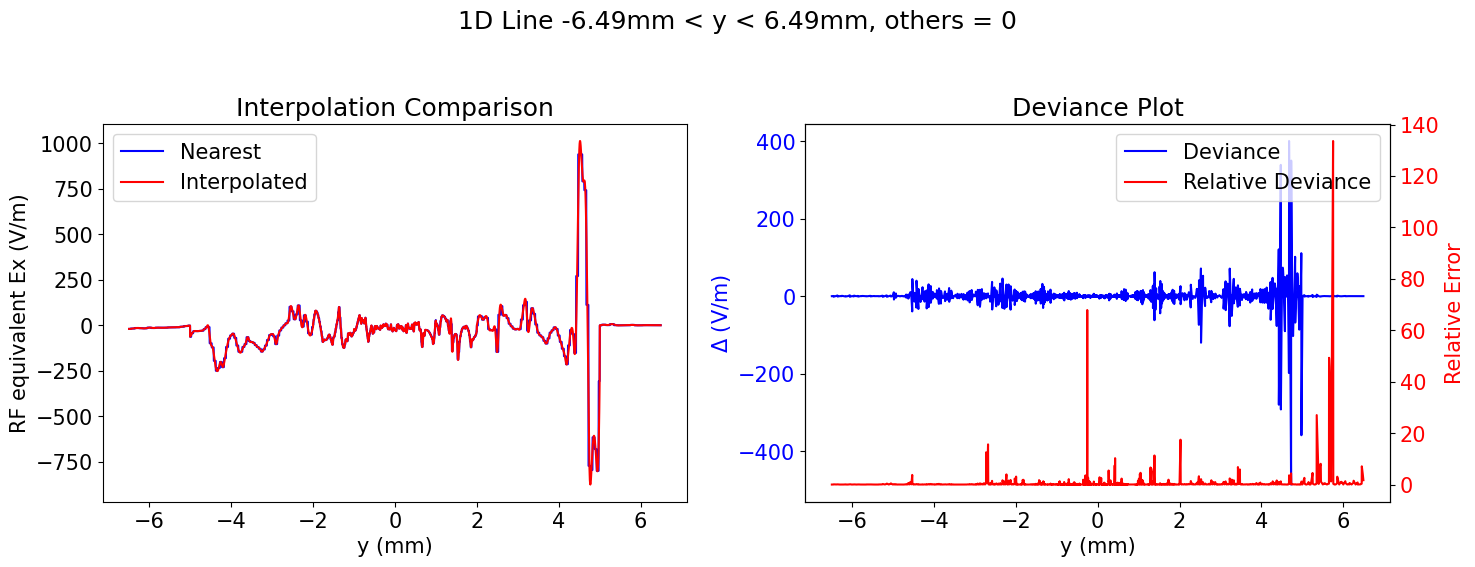

Computation time: 2.2378 seconds


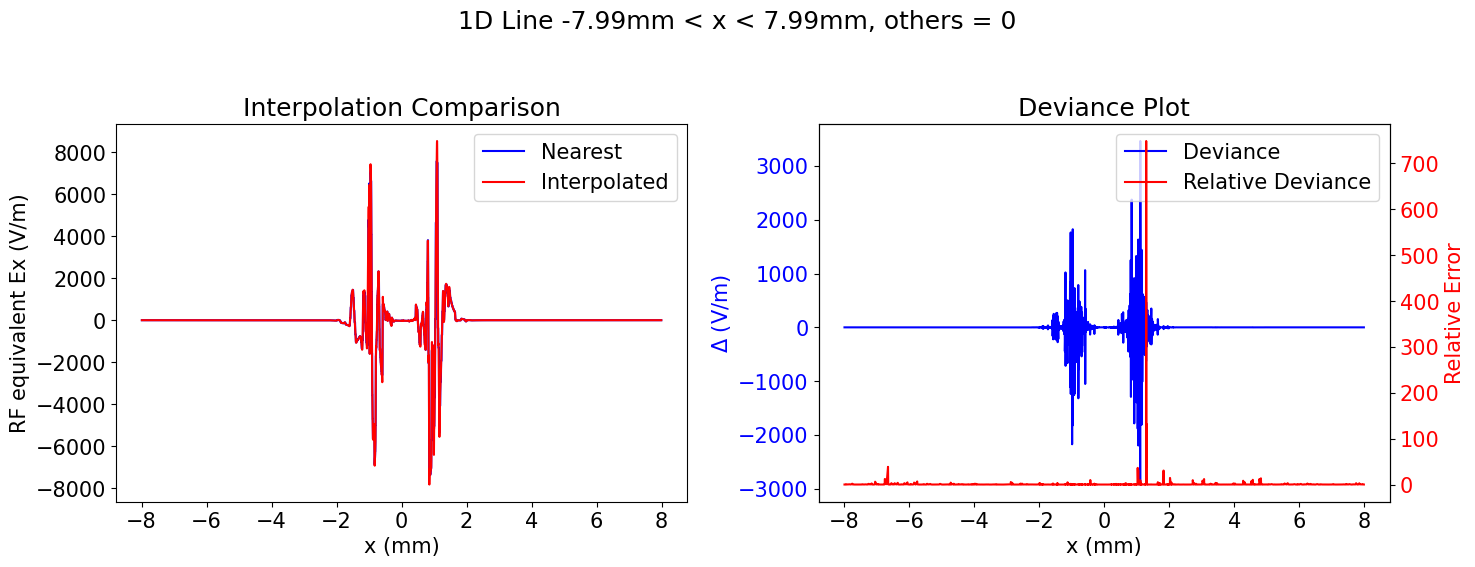

In [74]:
sample_and_plot_1D('y', (-0.00649, 0.00649), interp_funcs=test_z, ref_funcs=ref_z)
sample_and_plot_1D('x', (-0.00799, 0.00799), interp_funcs=test_z, ref_funcs=ref_z)

Computation time: 1.9517 seconds


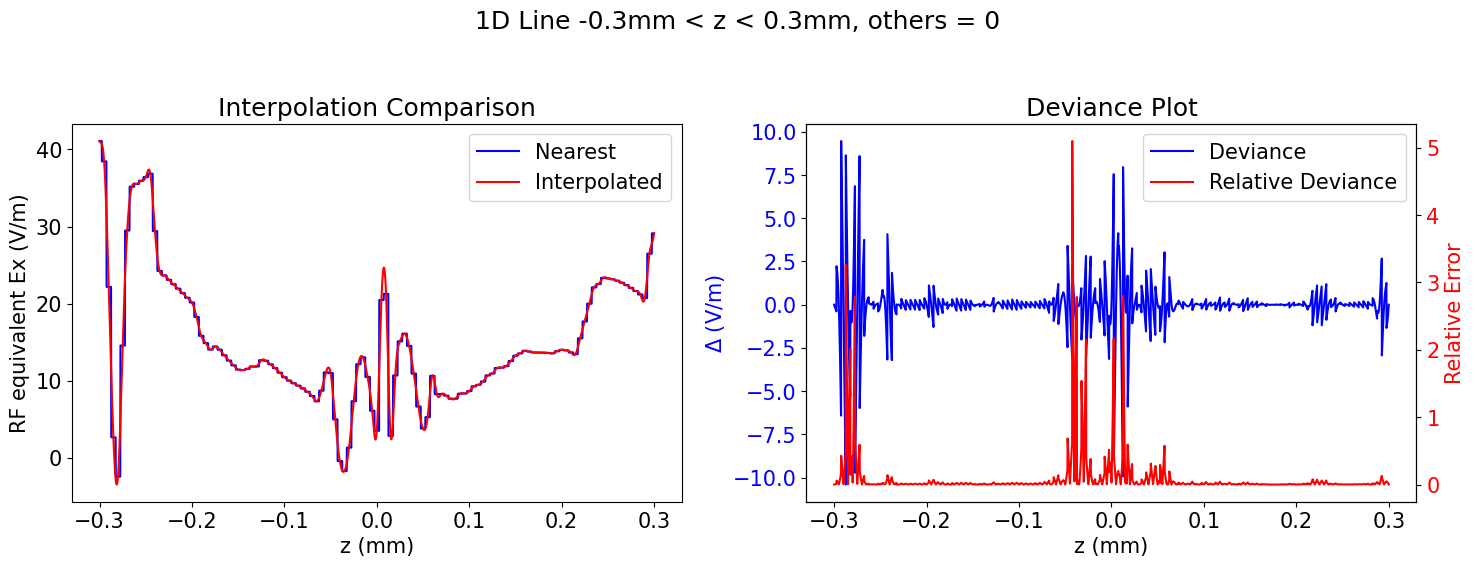

Computation time: 2.0715 seconds


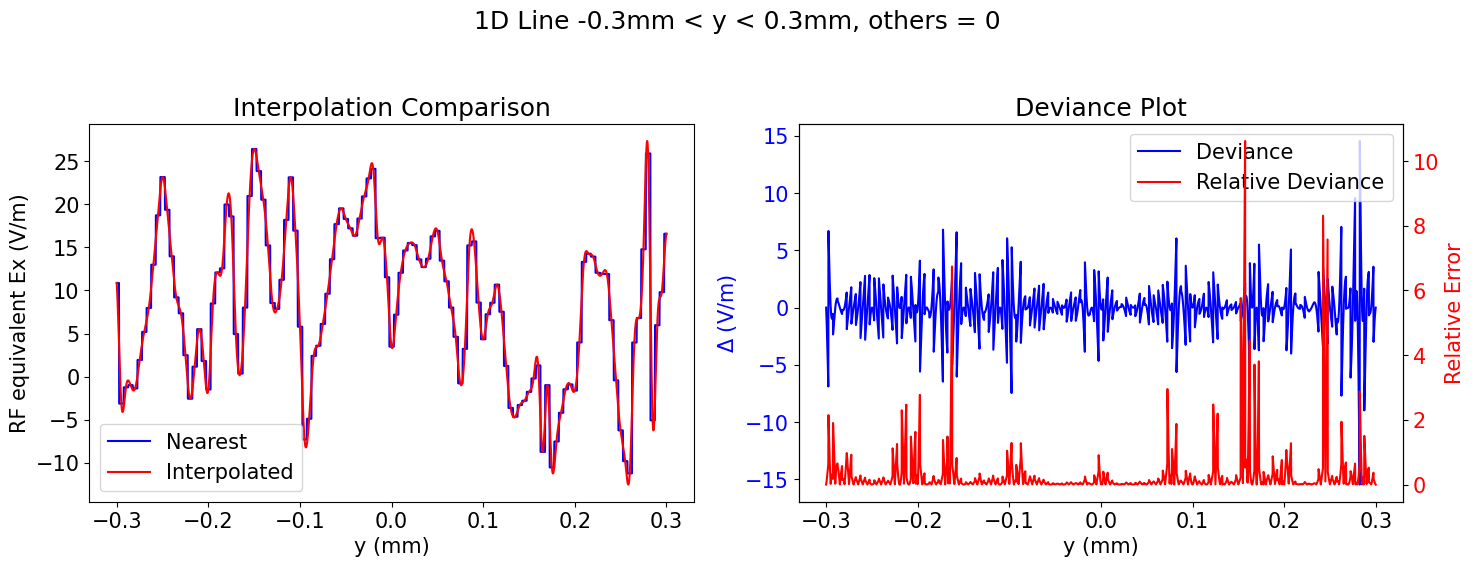

Computation time: 1.2588 seconds


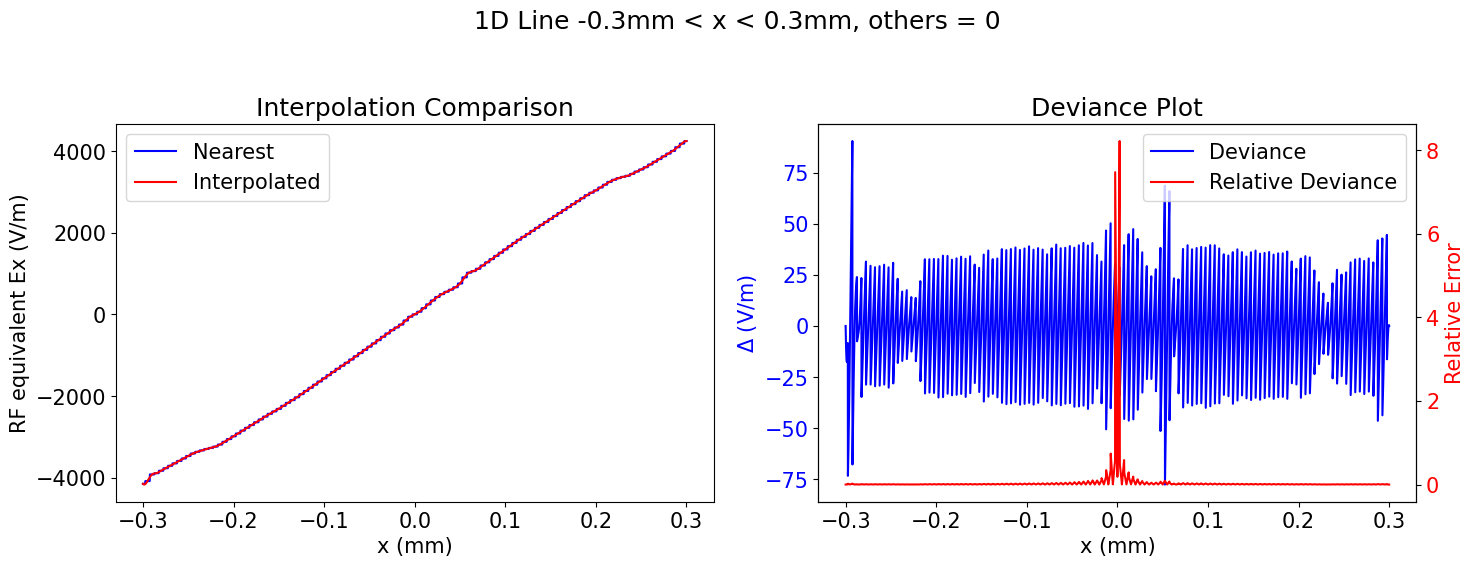

In [84]:
sample_and_plot_1D('z', (-0.00030, 0.00030), interp_funcs=test_x, ref_funcs=ref_x)
sample_and_plot_1D('y', (-0.00030, 0.00030), interp_funcs=test_x, ref_funcs=ref_x)
sample_and_plot_1D('x', (-0.00030, 0.00030), interp_funcs=test_x, ref_funcs=ref_x)

Computation time: 1.9730 seconds


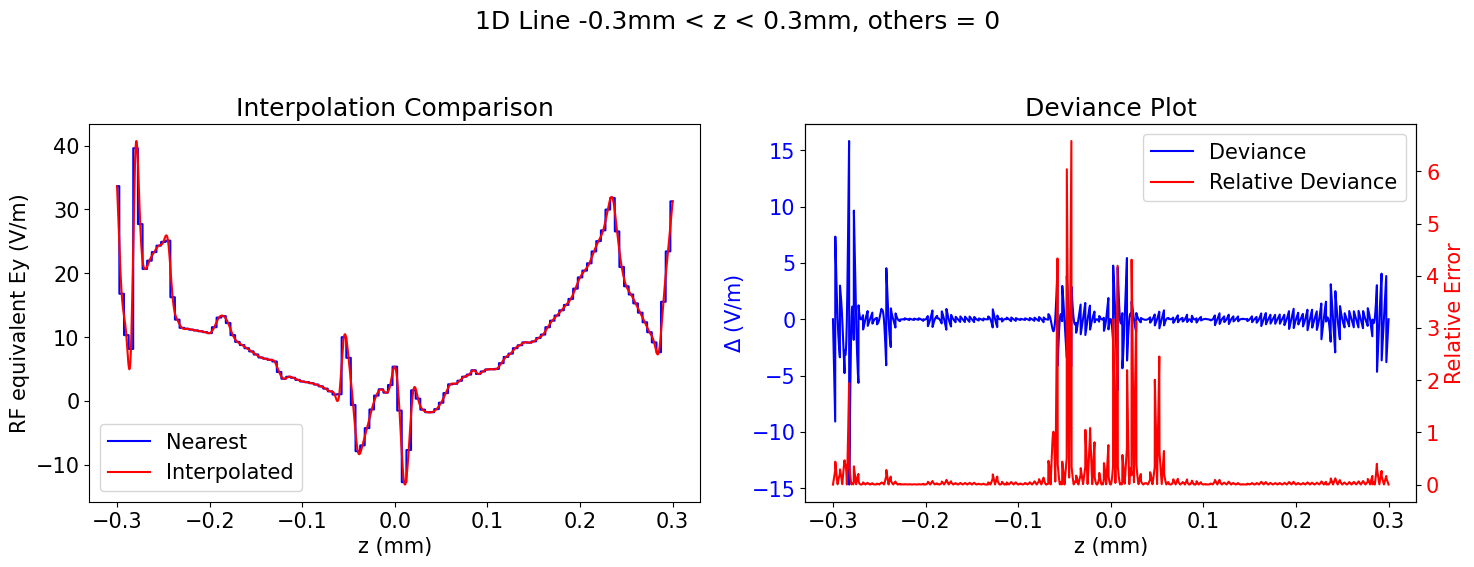

Computation time: 1.8648 seconds


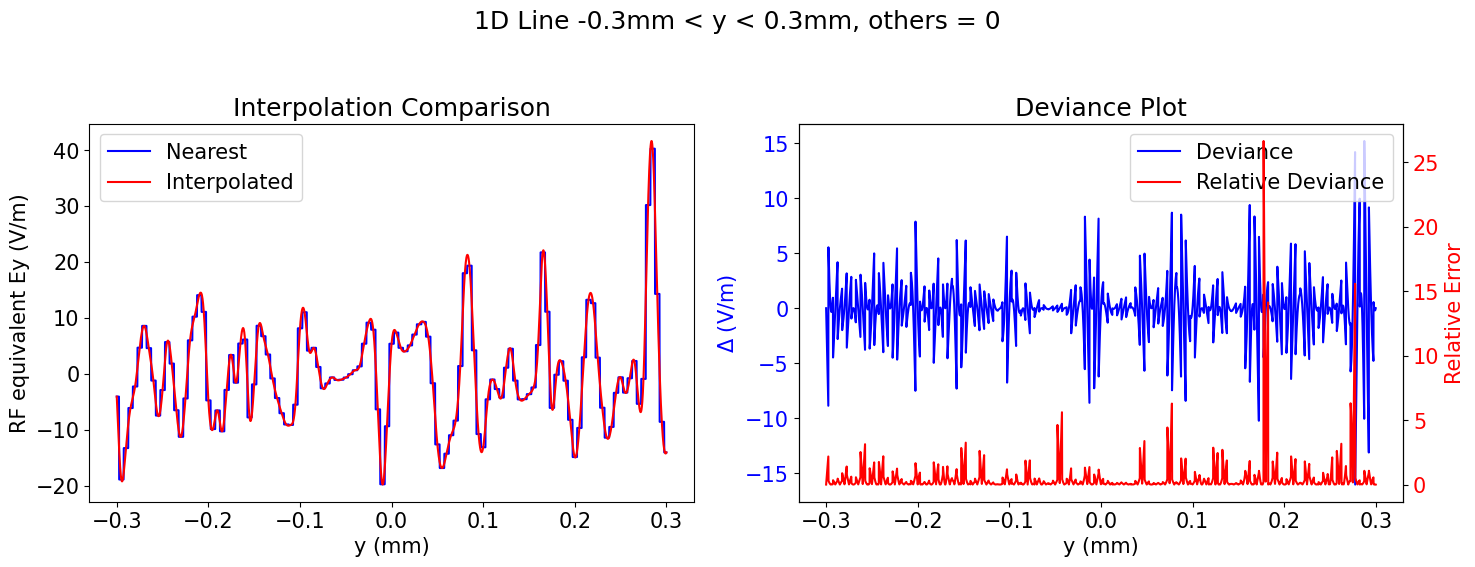

Computation time: 1.6659 seconds


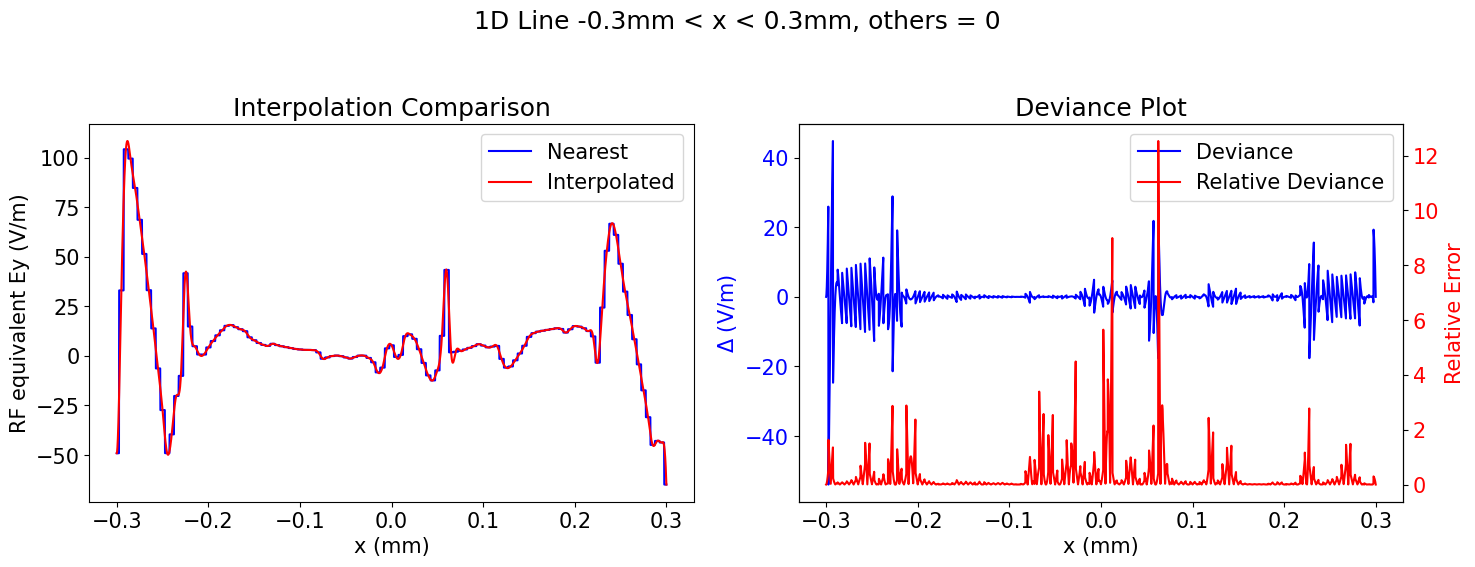

In [86]:
sample_and_plot_1D('z', (-0.00030, 0.00030), field='y', interp_funcs=test_y, ref_funcs=ref_y)
sample_and_plot_1D('y', (-0.00030, 0.00030), field='y', interp_funcs=test_y, ref_funcs=ref_y)
sample_and_plot_1D('x', (-0.00030, 0.00030), field='y', interp_funcs=test_y, ref_funcs=ref_y)

Computation time: 1.4632 seconds


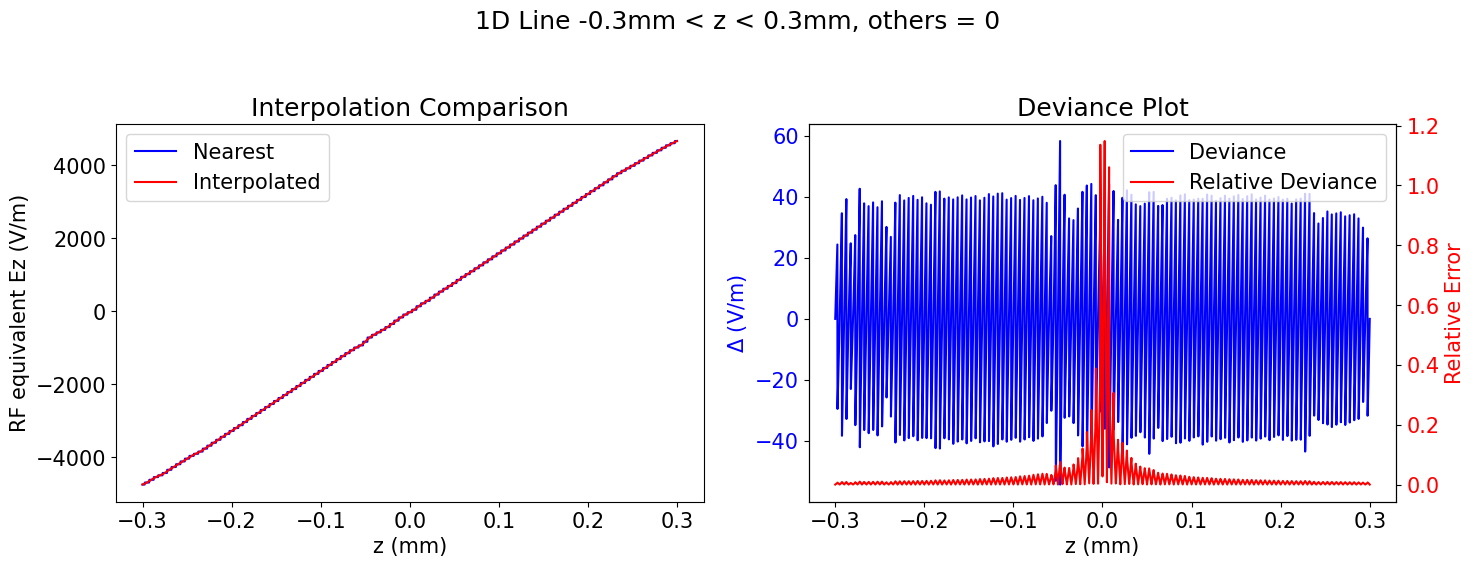

Computation time: 1.1317 seconds


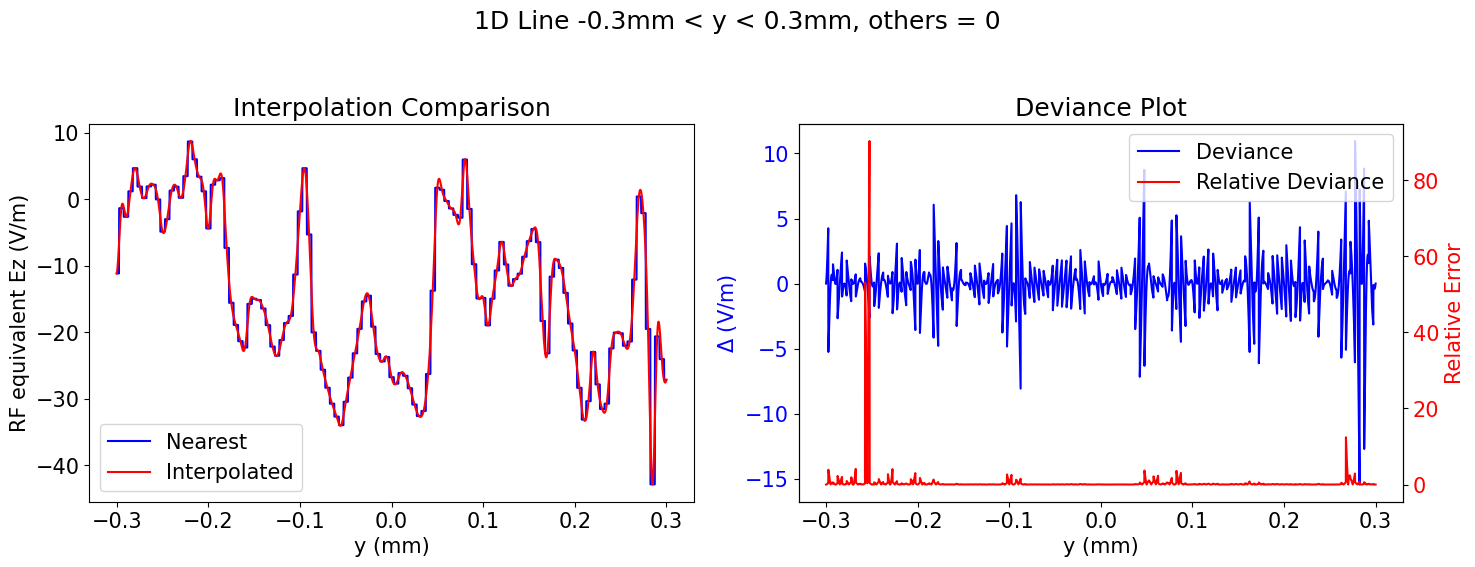

Computation time: 1.9039 seconds


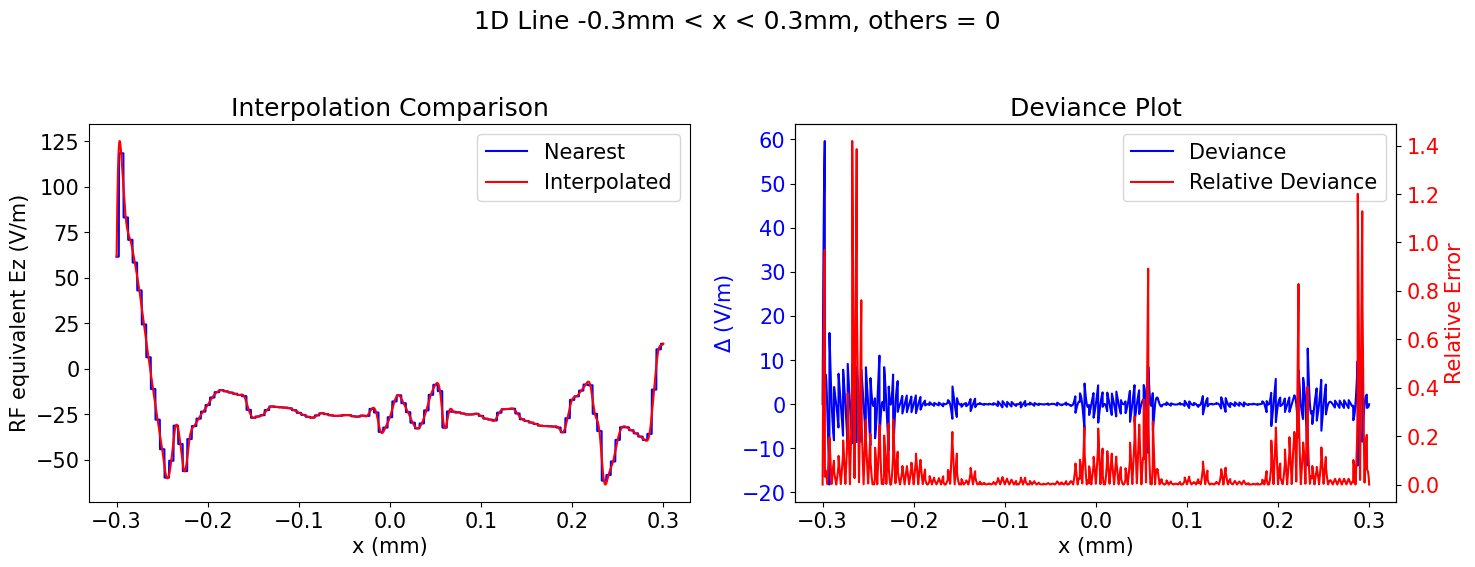

In [87]:
sample_and_plot_1D('z', (-0.00030, 0.00030), field='z', interp_funcs=test_z, ref_funcs=ref_z)
sample_and_plot_1D('y', (-0.00030, 0.00030), field='z', interp_funcs=test_z, ref_funcs=ref_z)
sample_and_plot_1D('x', (-0.00030, 0.00030), field='z', interp_funcs=test_z, ref_funcs=ref_z)